<a href="https://colab.research.google.com/github/Black3rror/AI/blob/master/CIFAR10_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

The goal is implimenting a model to solve MNIST from scratch (just numpy)

# Importing stuff

In [ ]:
import numpy as np
import tensorflow   # to compare with our classes
from tensorflow.keras.datasets.cifar10 import load_data

import matplotlib.pyplot as plt
import time

# New classes and functions

## Initializations

### Xavier initialization (He)

In [ ]:
"""
@brief Xavier or He initializer
@param w_dims: current layers param dimention (shape), like (3,) or (3,1) for dense or (2,2) for conv
@param l_dims: current layers dimention (shape), like (3,) or (3,1) for dense or (2,2) for conv
@return param: created parameter of shape l_dims
"""
def xavier(p_dims, l_1_dims):
  param = np.random.standard_normal(p_dims) / np.sqrt(np.prod(l_1_dims)) * 0.01
  param = param.reshape(p_dims)

  return param

In [ ]:
np.random.seed(1)
print(xavier((9, 1), (4, 1)))
np.random.seed(1)
print("\n", xavier((9,), (16,)))

np.random.seed(1)
print("\n\n", xavier((3, 3), (2, 2)))

[[ 0.00812173]
 [-0.00305878]
 [-0.00264086]
 [-0.00536484]
 [ 0.00432704]
 [-0.01150769]
 [ 0.00872406]
 [-0.00380603]
 [ 0.0015952 ]]

 [ 0.00406086 -0.00152939 -0.00132043 -0.00268242  0.00216352 -0.00575385
  0.00436203 -0.00190302  0.0007976 ]


 [[ 0.00812173 -0.00305878 -0.00264086]
 [-0.00536484  0.00432704 -0.01150769]
 [ 0.00872406 -0.00380603  0.0015952 ]]


### Zeros

In [ ]:
def zeros(l_dims):
  param = np.zeros(l_dims)
  return param

## Loss functions

### Categorical crossentropy

In [ ]:
"""
@return batch-result: averaged loss over batch, compressed to one number
@return gradient: averaged dL/dyhat over batch
      shapes
------------------
y:            (m, units) or (units)
yhat:         (m, units) or (units)
batch-result: float
gradient:     (m, units)

logp:            (m, units)
example_results: (m, 1)
"""
def categorical_crossentropy(y, yhat, epsilon = 1e-7):
  assert yhat.shape == y.shape
  assert len(y.shape) <= 2

  # if inputs are in shape of (n,) (one example) convert them to (1, n) (batch)
  if len(y.shape) == 1:
    yhat = yhat.reshape((1, -1))
    y = y.reshape((1, -1))
  
  logp = y * np.log(yhat+epsilon)
  example_results = np.sum(-logp, axis = 1, keepdims=True)
  batch_result = np.average(example_results)

  gradient = -1 * (y / (yhat+epsilon) - (1-y) / (1-yhat+epsilon))    # dLn(x)/dx = 1/x

  return batch_result, gradient

In [ ]:
a = np.array([0,   0,   1])
b = np.array([0.7, 0.1, 0.2])
c = np.array([[0,   0,   1],   [1,   0,   0],   [0,   0,   1],   [0,   1,   0]])
d = np.array([[0.7, 0.2, 0.1], [0.8, 0.2, 0.0], [0.5, 0.2, 0.3], [0.1, 0.7, 0.2]])

print("my loss: ", categorical_crossentropy(a, b)[0])

loss = tensorflow.keras.losses.categorical_crossentropy(a, b)
print("tf loss: ", loss.numpy())

print("my loss: ", categorical_crossentropy(c, d)[0])

loss = tensorflow.keras.losses.categorical_crossentropy(c, d)
print("tf loss: ", np.average(loss.numpy()))

my loss:  1.6094374124342252
tf loss:  1.6094379124341003
my loss:  1.0215936978457554
tf loss:  1.021594098143231


## Optimizers

### Adam

In [ ]:
class Adam():
  def __init__(self, learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, step = 1, epsilon = 1e-7):
    self.learning_rate = learning_rate
    self.beta1 = beta_1
    self.beta2 = beta_2
    self.step = step
    self.epsilon = epsilon
    self.first_moment = None
    self.second_moment = None
  
  """
        shapes
  ------------------
  vars:         (vars, 1)
  grads:        (vars, 1)
  vars_changes: (vars, 1)
  """
  def __call__(self, vars, grads, step = None):
    assert len(vars.shape) == 2
    assert vars.shape[1] == 1
    assert vars.shape == grads.shape
    if isinstance(step, int):
      self.step = step
    
    vars_changes = self.compute_changes(grads)
    return vars + vars_changes
  
  """
  @brief computes the amount changes needed for optimize variables
        shapes
  ------------------
  grads:        (vars, 1)
  changes: (vars, 1)
  """
  def compute_changes(self, grads, step = None):
    if self.first_moment is None:
      self.first_moment = np.zeros_like(grads)
      self.second_moment = np.zeros_like(grads)

    assert self.first_moment.shape == grads.shape
    assert self.second_moment.shape == grads.shape
    
    if isinstance(step, int):
      self.step = step

    self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * grads
    self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * grads * grads
    first_unbiased = self.first_moment / (1 - self.beta1 ** self.step)
    second_unbiased = self.second_moment / (1 - self.beta2 ** self.step)

    changes = - self.learning_rate * first_unbiased / (np.sqrt(second_unbiased + self.epsilon))
    return changes

[[1.099]
 [2.199]
 [3.301]]


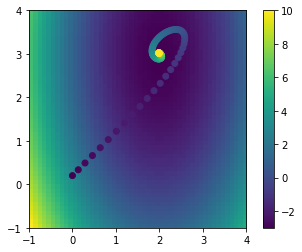

In [ ]:
a = np.array([1.1, 2.2, 3.3]).reshape(-1, 1)
b = np.array([0.5, 5, -0.3]).reshape(-1, 1)
opt = Adam()
print(opt(a, b))

# optimization problem
x1 = -0.1
x2 = 0.1
def myfunc(x1, x2):
  return (x1 - 2)**2 + (0.5*x2 - 1.5)**2 - 3
opt = Adam(learning_rate=0.1)

x1g, x2g = np.meshgrid(np.linspace(-1, 4), np.linspace(-1, 4))
plt.figure()
plt.imshow(myfunc(x1g, x2g), extent=[-1, 4, -1, 4], origin="lower")
plt.colorbar()

x1_history = np.zeros((100,1))
x2_history = np.zeros((100,1))
for i in range(100):
  dx1 = 2*(x1 - 2)
  dx2 = 2*(0.5*x2 - 1.5)
  [[x1], [x2]] = opt(np.array([[x1], [x2]]), np.array([[dx1], [dx2]]))
  x1_history[i] = x1
  x2_history[i] = x2

plt.scatter(x1_history, x2_history, c=range(100))
plt.show()
  

## Layers

### Dense

In [ ]:
"""
      shapes
------------------
w: (units_prev, units)
b: (units, 1)
X: (m, units_prev)
z: (m, units)

grads_upstream:   (m, units)
grads_downstream: (m, units_prev)
dw:               (units_prev, units)
db:               (units, 1)
vars:             (vars, 1)
dvars:            (vars, 1)
"""
class Dense():
  def __init__(self, units, kernel_initializer = "xavier", bias_initializer = "zeros"):
    self.units = units
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.w = None
    self.b = None
  
  def __call__(self, X):
    return self.forward(X)
  
  def get_weights(self):
    return {"weights": self.w, "biases": self.b}
  
  def get_trainables_count(self):
    count = 0
    if self.w is not None:
      count += np.prod(self.w.shape)
    if self.b is not None:
      count += np.prod(self.b.shape)
    return count

  def forward(self, X):
    assert len(X.shape) == 2

    if self.w is None:
      if self.kernel_initializer == "xavier":
        self.w = xavier((X.shape[1], self.units), (X.shape[1],))
      elif self.kernel_initializer == "zeros":
        self.w = zeros((X.shape[1], self.units))

    if self.b is None:
      if self.bias_initializer == "xavier":
        self.b = xavier((self.units, 1), (1,))
      elif self.bias_initializer == "zeros":
        self.b = zeros((self.units, 1))
    
    self.X = X
    self.z = np.dot(X, self.w) + self.b.T
    
    return self.z
  
  """
  @param grads_upstream: incoming grad with shape (m, units)
  """
  def backward(self, grads_upstream):
    assert grads_upstream.shape == self.z.shape
    db = np.average(grads_upstream, axis = 0).reshape(self.b.shape)
    dw = np.dot(self.X.T, grads_upstream) / self.X.shape[0]
    grads_downstream = np.dot(grads_upstream, self.w.T)
    vars = np.concatenate((self.w.reshape((-1, 1)), self.b))
    dvars = np.concatenate((dw.reshape(-1, 1), db))
    assert len(vars.shape) == 2
    assert vars.shape[1] == 1
    assert vars.shape == dvars.shape
    return grads_downstream, vars, dvars
  
  def set_weights(self, vars):
    assert vars.shape[0] == self.get_trainables_count()
    assert vars.shape[1] == 1
    assert len(vars.shape) == 2
    self.w = vars[:np.prod(self.w.shape)].reshape(self.w.shape)
    self.b = vars[-np.prod(self.b.shape):].reshape(self.b.shape)

In [ ]:
X = np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]])
dense = Dense(2)

dense(X)
print("weights and biases: \n", dense.get_weights())
stream, vars, dvars = dense.backward(np.array([[1, 1], [1, 1], [1, 1], [1, 1]]))
print("\ngradient stream: \n", stream)
print("\ndw db: \n", dvars)

weights and biases: 
 {'weights': array([[-0.00143974,  0.00844148],
       [-0.01189423, -0.00186148],
       [-0.00221734,  0.00654582]]), 'biases': array([[0.],
       [0.]])}

gradient stream: 
 [[ 0.00700174 -0.0137557   0.00432848]
 [ 0.00700174 -0.0137557   0.00432848]
 [ 0.00700174 -0.0137557   0.00432848]
 [ 0.00700174 -0.0137557   0.00432848]]

dw db: 
 [[1.]
 [1.]
 [2.]
 [2.]
 [3.]
 [3.]
 [1.]
 [1.]]


### ReLU

In [ ]:
"""
      shapes
------------------
X: (m, units)
z: (m, units)

grads_upstream:   (m, units)
grads_downstream: (m, units)
"""
class ReLU():
  def __init__(self):
    pass
    
  def __call__(self, X):
    return self.forward(X)
  
  def get_trainables_count(self):
    return 0
  
  def forward(self, X):
    assert len(X.shape) == 2
    self.z = np.maximum(X, 0)
    assert len(self.z.shape) == 2
    return self.z
  
  """
  @param grads_upstream: incoming grad with shape (m, units)
  """
  def backward(self, grads_upstream):
    assert len(grads_upstream.shape) == 2
    assert grads_upstream.shape == self.z.shape
    grads_downstream = grads_upstream * (self.z > 0)
    assert len(grads_downstream.shape) == 2
    assert grads_downstream.shape == self.z.shape
    return grads_downstream, None, None
  
  def set_weights(self, vars):
    pass

In [ ]:
X = np.array([[1, 2, 3], [1, -2, 3], [1, 2, -3], [1, 2, 3]])
relu = ReLU()

print("output: \n", relu(X))
stream, vars, dvars = relu.backward(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]))
print("\ngradient stream: \n", stream)

output: 
 [[1 2 3]
 [1 0 3]
 [1 2 0]
 [1 2 3]]

gradient stream: 
 [[1 1 1]
 [1 0 1]
 [1 1 0]
 [1 1 1]]


### Softmax

In [ ]:
"""
      shapes
------------------
X: (m, units)
z: (m, units)

grads_upstream:   (m, units)
grads_downstream: (m, units)
"""
class Softmax():
  def __init__(self):
    pass
    
  def __call__(self, X):
    return self.forward(X)
  
  def get_trainables_count(self):
    return 0
  
  def forward(self, X):
    assert len(X.shape) == 2
    self.z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape((-1, 1))
    return self.z
  
  """
  @param grads_upstream: incoming grad with shape (m, units)
  """
  def backward(self, grads_upstream):
    assert len(grads_upstream.shape) == 2
    assert grads_upstream.shape == self.z.shape
    grads_downstream = grads_upstream * (self.z * (1 - self.z))
    return grads_downstream, None, None
  
  def set_weights(self, vars):
    pass

In [ ]:
X = np.array([[3, 3, 3], [1, -2, 3], [1, 2, -3], [1, 2, 3]])
softmax = Softmax()

print("output: \n", softmax(X))
stream, vars, dvars = softmax.backward(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]))
print("\ngradient stream: \n", stream)

output: 
 [[0.33333333 0.33333333 0.33333333]
 [0.11849965 0.00589975 0.8756006 ]
 [0.26762315 0.72747516 0.00490169]
 [0.09003057 0.24472847 0.66524096]]

gradient stream: 
 [[0.22222222 0.22222222 0.22222222]
 [0.10445749 0.00586494 0.10892419]
 [0.196001   0.19825505 0.00487766]
 [0.08192507 0.18483645 0.22269543]]


## Models

### Sequential

In [ ]:
"""
      shapes
------------------
layers:    list
optimizer: class instance
loss_func: func
accuracy:  func or None
"""
class Sequential():
  def __init__(self):
    self.layers = []
    self.optimizer = None
    self.loss_func = None
    self.accuracy = None
  
  def __call__(self, X):
    return self.forward(X)

  def add(self, layer):
    self.layers.append(layer)

  def forward(self, X):
    for layer in self.layers:
      X = layer(X)
    return X
  
  def compile(self, optimizer='adam', loss='categorical_crossentropy', accuracy=None):
    if optimizer == "adam":
      self.optimizer = Adam()
    if loss == "categorical_crossentropy":
      self.loss_func = categorical_crossentropy
    if isinstance(optimizer, Adam):
      self.optimizer = optimizer
    if accuracy == "categorical_accuracy":
      self.accuracy = categorical_accuracy
  
  def fit(self, trainX, trainy, batch_size = 32, epochs = 1, validation_data = None, shuffle = True):
    assert len(trainX.shape) == 2
    assert len(trainy.shape) == 2
    for i in range(epochs):
      tic = time.time()
      if shuffle == True:
        trainX, trainy = self.__shuffle(trainX, trainy)
      
      train_loss = 0
      train_acc = 0
      for batch_start in range(0, len(trainX), batch_size):
        batchX = trainX[batch_start: batch_start + batch_size]
        batchy = trainy[batch_start: batch_start + batch_size]
        t_loss, t_acc = self.__train_batch(batchX, batchy)
        train_loss += t_loss
        if t_acc is not None:
          train_acc += t_acc
      train_loss = train_loss / ((len(trainX)+batch_size-1)//batch_size)
      train_acc = train_acc / ((len(trainX)+batch_size-1)//batch_size)
      
      if validation_data is not None:
        assert len(validation_data[0].shape) == 2
        assert len(validation_data[1].shape) == 2
        yhat = self.forward(validation_data[0])
        val_loss, _ = self.loss_func(validation_data[1], yhat)
        if self.accuracy is not None:
          val_acc = self.accuracy(validation_data[1], yhat)
      
      toc = time.time()
      if validation_data is None:
        if self.accuracy is None:
          print("Epoch %d ended (in %.2fs): loss = %.4f".format(i, toc-tic, train_loss))
        else:
          print("Epoch %d ended (in %.2fs): loss = %.4f    accuracy = %.4f".format(i, toc-tic, train_loss, train_acc))
      else:
        if self.accuracy is None:
          print("Epoch %d ended (in %.2fs): loss = %.4f    val_loss = ".format(i, toc-tic, train_loss, val_loss))
        else:
          print("Epoch %d ended (in %.2fs): loss = %.4f    accuracy = %.4f    val_loss = %.4f    val_accuracy = %.4f" %
                (i, toc-tic, train_loss, train_acc, val_loss, val_acc))

  
  def __shuffle(self, x, y):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    return x[p], y[p]
  
  def __train_batch(self, x, y):
    yhat = self.forward(x)
    loss, stream = self.loss_func(y, yhat)
    accuracy = None
    if self.accuracy is not None:
      accuracy = self.accuracy(y, yhat)
    vars = None
    dvars = None
    for layer in reversed(self.layers):
      stream, var, dvar = layer.backward(stream)
      if vars is None:
        vars = var
      elif var is not None:
        vars = np.concatenate((vars, var))
      if dvars is None:
        dvars = dvar
      elif dvar is not None:
        dvars = np.concatenate((dvars, dvar))
    assert len(vars.shape) == 2
    assert vars.shape[1] == 1
    assert vars.shape == dvars.shape

    vars_changed = self.optimizer(vars, dvars)

    for layer in reversed(self.layers):
      trainables_count = layer.get_trainables_count()
      layer.set_weights(vars_changed[:trainables_count])
      vars_changed = vars_changed[trainables_count:]
    
    return loss, accuracy

## Other stuff

### to_categorical

In [ ]:
def to_categorical(y):
  min = np.min(y)
  max = np.max(y)
  ycat = np.zeros((y.shape[0], max-min+1))
  for i in range(len(y)):
    ycat[i, y[i]-min] = 1
  return ycat

### categorical_accuracy

In [ ]:
"""
      shapes
------------------
y, yhat: (m, units)
"""
def categorical_accuracy(y, yhat):
  y = np.argmax(y, axis = 1)
  yhat = np.argmax(yhat, axis = 1)
  match = (y == yhat)
  return np.sum(match) / len(match)

In [ ]:
a = [[0,   0,   1,   0,   0  ], [0,   0,   1,   0,   0  ], [0,   0,   1,   0,   0  ]]
b = [[0.1, 0.2, 0.4, 0.1, 0.1], [0.1, 0.6, 0.2, 0.1, 0.0], [0.1, 0.1, 0.8, 0.0, 0.0]]
print(categorical_accuracy(a, b))

0.6666666666666666


# Initialization

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


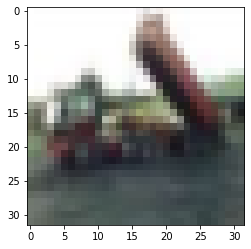

In [ ]:
(trainX_2d, trainy_int), (testX_2d, testy_int) = load_data()

trainX = trainX_2d.reshape(trainX_2d.shape[0], -1)
testX = testX_2d.reshape(testX_2d.shape[0], -1)

trainy = to_categorical(trainy_int)
testy = to_categorical(testy_int)

trainX = trainX.astype("float32")/255
testX = testX.astype("float32")/255

# show a test
plt.imshow(trainX_2d[2])
print(trainy[2])

# Build the model

In [ ]:
model = Sequential()
model.add(Dense(10))
model.add(Softmax())

# Train the model

In [ ]:
model = Sequential()
model.add(Dense(10))
model.add(Softmax())
opt = Adam(0.001)
model.compile(optimizer = opt, loss = "categorical_crossentropy", accuracy = "categorical_accuracy")
model.fit(trainX, trainy, epochs = 50, validation_data = (testX, testy))

Epoch 0 ended (in 3.84s): loss = 1.8901    accuracy = 0.3366    val_loss = 1.8111    val_accuracy = 0.3746
Epoch 1 ended (in 4.01s): loss = 1.7983    accuracy = 0.3736    val_loss = 1.8258    val_accuracy = 0.3547
Epoch 2 ended (in 3.82s): loss = 1.7801    accuracy = 0.3803    val_loss = 1.8101    val_accuracy = 0.3636
Epoch 3 ended (in 3.96s): loss = 1.7652    accuracy = 0.3887    val_loss = 1.7538    val_accuracy = 0.3889
Epoch 4 ended (in 3.94s): loss = 1.7591    accuracy = 0.3912    val_loss = 1.7685    val_accuracy = 0.3823
Epoch 5 ended (in 3.79s): loss = 1.7471    accuracy = 0.3974    val_loss = 1.7458    val_accuracy = 0.3892
Epoch 6 ended (in 3.79s): loss = 1.7415    accuracy = 0.3972    val_loss = 1.8059    val_accuracy = 0.3750
Epoch 7 ended (in 3.75s): loss = 1.7342    accuracy = 0.3991    val_loss = 1.7665    val_accuracy = 0.3771
Epoch 8 ended (in 3.79s): loss = 1.7297    accuracy = 0.4025    val_loss = 1.7761    val_accuracy = 0.3788
Epoch 9 ended (in 3.79s): loss = 1.72